### Intuition
Now that we have our data prepared, we can start training our models to optimize on our objective. Ideally, we would start with the simplest possible baseline and slowly add complexity to our models:

1. Start with a random (chance) model. 
> Since we have four classes, we may expect a random model to be correct around 25% of the time but recall that not all of our classes have equal counts.

Develop a rule-based approach using if-else statements, regular expressions, etc.
We could build a list of common words for each class and if a word in the input matches a word in the list, we can predict that class.

Slowly add complexity by addressing limitations and motivating representations and model architectures.
We could start with a simple term frequency (TF-IDF) mode and then move onto embeddings with CNNs, RNNs, Transformers, etc.

Weigh tradeoffs (performance, latency, size, etc.) between performant baselines.
Revisit and iterate on baselines as your dataset grows and new model architectures are developed.
We're going to skip straight to step 3 of developing a complex model because this task involves unstructured data and rule-based systems are not well suited for this. And with the increase adoption of large language models (LLMs) as a proven model architecture for NLP tasks, we'll fine-tune a pretrained LLM on our dataset.

In [1]:
import cohere
cohere.api_key="cohere_api_key"

In [2]:
import pandas as pd

In [3]:
# Load training data
train_df = pd.read_csv("dataset.csv")
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [4]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [5]:
# Load inference dataset
test_df = pd.read_csv("holdout.csv")
test_df.head()

,id,created_on,title,description,tag
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing


### Utilities
We'll define a few utility functions to make the OpenAI request and to store our predictions. While we could perform batch prediction by loading samples until the context length is reached, we'll just perform one at a time since it's not too many data points and we can have fully deterministic behavior (if you insert new data, etc.). We'll also added some reliability in case we overload the endpoints with too many request at once.

In [6]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

We'll first define what a sample call to the OpenAI endpoint looks like. We'll pass in: - `system_content` that has information about how the LLM should behave. - `assistant_content` for any additional context it should have for answering our questions. - `user_content` that has our message or query to the `LLM. - model` should specify which specific model we want to send our request to.

We can pass all of this information in through the cohere.Client(api_key), client.chat function to receive our response.

In [7]:
# import openai
# openai.api_key = "api_key"


# from openai import OpenAI

# client = OpenAI(
#     # This is the default and can be omitted
#     api_key = "api_key",
# )

# # Query OpenAI endpoint
# system_content = "you only answer in rhymes"  # system content (behavior)
# assistant_content = ""  # assistant content (context)
# user_content = "how are you"  # user content (message)
# response = client.chat.completions.create(
#     model="gpt-3.5-turbo",
#     messages=[
#         {"role": "system", "content": system_content},
#         {"role": "assistant", "content": assistant_content},
#         {"role": "user", "content": user_content},
#     ],
# )
# print (response.to_dict()["choices"][0].to_dict()["message"]["content"])

In [8]:
import cohere

# Initialize the Cohere client with your API key
client = cohere.Client(api_key="cohere_api_key")

# Define the conversation messages
system_content = "you only answer in rhymes"
assistant_content = ""
user_content = "how are you"

# Format the messages as strings
chat_input = f"system: {system_content}\nuser: {user_content}"


# Send the messages to Cohere for processing
response = client.chat(
    model="command-r",
    message=chat_input,
)


In [9]:
print(response.text)

Fine and dandy, thanks for asking!
I'm doing just great, no complaints, really!


Now, let's create a function that can predict tags for a given sample.

In [10]:
def get_tag(model, system_content, assistant_content, user_content):
    try:
        # Send the messages to Cohere for processing
        response = client.chat(
            model=model,
            message=f"system: {system_content}\nuser: {user_content}",
        )
        predicted_tag = response.text
        return predicted_tag
    except cohere.error.ServiceUnavailableError as e:
        print(f"Service unavailable error: {e}")
    except cohere.error.APIError as e:
        print(f"API error: {e}")
    return None

In [11]:
model = "command-r"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."

# Get the predicted tag
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print(tag)

natural-language-processing


Next, let's create a function that can predict tags for a list of inputs.

In [12]:
# List of dicts w/ {title, description} (just the first 3 samples for now)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
samples

[{'title': 'Diffusion to Vector',
  'description': 'Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. '},
 {'title': 'Graph Wavelet Neural Network',
  'description': 'A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) '},
 {'title': 'Capsule Graph Neural Network',
  'description': 'A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).'}]

In [13]:
def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None:
            time.sleep(30)  # could also do exponential backoff
            predicted_tag = get_tag(
                model=model, system_content=system_content,
                assistant_content=assistant_content, user_content=user_content)

        # Add to list of predictions
        y_pred.append(predicted_tag)

    return y_pred

In [14]:
# Get predictions for a list of inputs
get_predictions(inputs=samples, model=model, system_content=system_context)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


['natural-language-processing',
 'computer-vision',
 'natural-language-processing']

Next we'll define a function that can clean our predictions in the event that it's not the proper format or has hallucinated a tag outside of our expected tags.

In [15]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

Next, we'll define a function that will plot our ground truth labels and predictions.

In [16]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

And finally, we'll define a function that will combine all the utilities above to predict, clean and plot our results.

In [17]:
def evaluate(test_df, model, system_content, tags, assistant_content=""):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

### Zero-shot learning
Now we're ready to start benchmarking our different LLMs with different context.

In [18]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

We'll start with zero-shot learning which involves providing the model with the `system_content` that tells it how to behave but no examples of the behavior (no `assistant_content`).


In [19]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]
c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{
  "precision": 0.48,
  "recall": 0.6,
  "f1": 0.5142857142857145
}


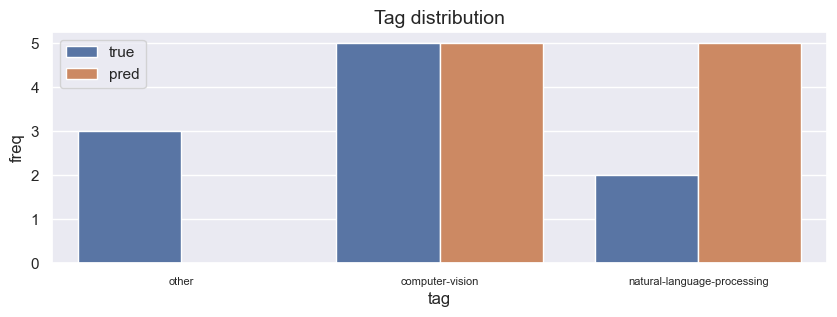

In [23]:
# Zero-shot with GPT 3.5
method = "zero_shot"
model = "command-r"
test_df= test_df.head(10)
# "sk-proj-V0n02XouK3Wi1rxVXelxT3BlbkFJspIApQo6aBztPlIC4Tcw"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


{
  "precision": 0.58,
  "recall": 0.3,
  "f1": 0.280952380952381
}


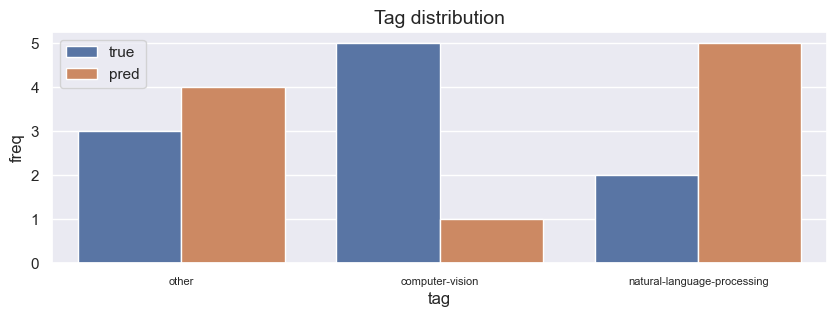

In [27]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "command-r-plus"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

### Few-shot learning
Now, we'll be adding a assistant_context with a few samples from our training data for each class. The intuition here is that we're giving the model a few examples (few-shot learning) of what each class looks like so that it can learn to generalize better.

In [28]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.',
  'tag': 'other'},
 {'title': 'Awesome Monte Carlo Tree Search',
  'description': 'A curated list of Monte Carlo tree search papers with implementations. ',
  'tag': 'other'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance througho

In [29]:
# Add assistant context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}, {'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhib

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]
c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{
  "precision": 0.48,
  "recall": 0.6,
  "f1": 0.5142857142857145
}


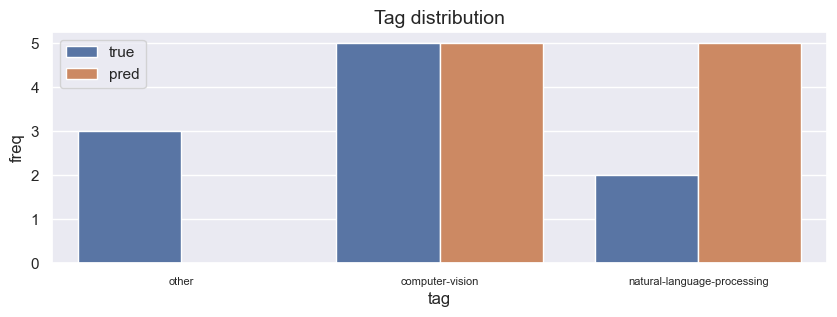

In [30]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "command-r"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


{
  "precision": 0.58,
  "recall": 0.3,
  "f1": 0.280952380952381
}


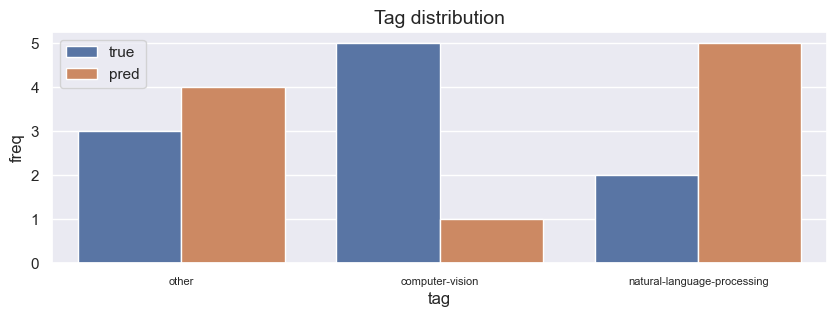

In [32]:
# Few-shot with GPT 4
method = "few_shot"
model = "command-r-plus"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

As we can see, few shot learning performs better than it's respective zero shot counter part. command-r-plus has had considerable improvements in reducing hallucinations but for our supervised task this comes at an expense of high precision but lower recall and f1 scores. When GPT 4 is not confident, it would rather predict other.

### Results
Now let's compare all the results from our generative AI LLM benchmarks:

In [33]:
print(json.dumps(performance, indent=2))

{
  "zero_shot": {
    "command-r": {
      "precision": 0.48,
      "recall": 0.6,
      "f1": 0.5142857142857145
    },
    "command-r-plus": {
      "precision": 0.58,
      "recall": 0.3,
      "f1": 0.280952380952381
    }
  },
  "few_shot": {
    "command-r": {
      "precision": 0.48,
      "recall": 0.6,
      "f1": 0.5142857142857145
    },
    "command-r-plus": {
      "precision": 0.58,
      "recall": 0.3,
      "f1": 0.280952380952381
    }
  }
}


And we can plot these on a bar plot to compare them visually.

In [34]:
# Transform data into a new dictionary with four keys
by_model_and_context = {}
for context_type, models_data in performance.items():
    for model, metrics in models_data.items():
        key = f"{model}_{context_type}"
        by_model_and_context[key] = metrics

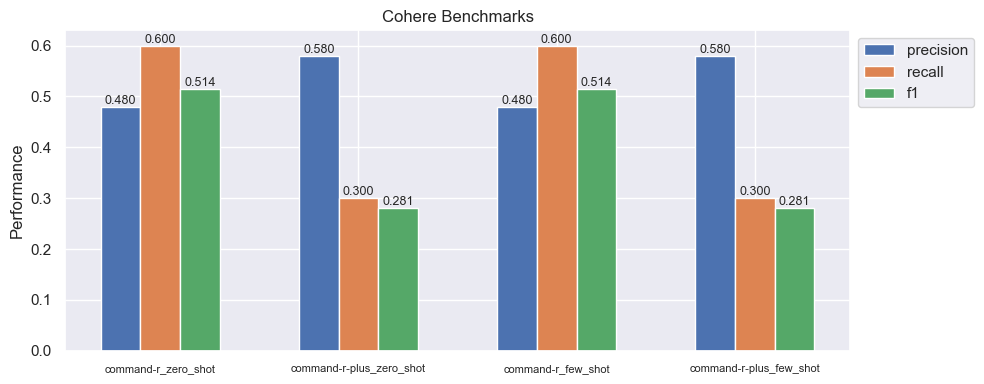

In [36]:
# Extracting the model names and the metric values
models = list(by_model_and_context.keys())
metrics = list(by_model_and_context[models[0]].keys())

# Plotting the bar chart with metric scores on top of each bar
fig, ax = plt.subplots(figsize=(10, 4))
width = 0.2
x = range(len(models))

for i, metric in enumerate(metrics):
    metric_values = [by_model_and_context[model][metric] for model in models]
    ax.bar([pos + width * i for pos in x], metric_values, width, label=metric)
    # Displaying the metric scores on top of each bar
    for pos, val in zip(x, metric_values):
        ax.text(pos + width * i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(models, rotation=0, ha='center', fontsize=8)
ax.set_ylabel('Performance')
ax.set_title('Cohere Benchmarks')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()